<img src="../img/hu-logo.png" align="right" width="120">

# Weight initialization

We'll look at three ways to initialize weights:
1. Normal and uniform
1. Xavier (aka Glorot)
1. Kaiming (aka He)

Our focus will be to monitor the activations (mean and standard deviation).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing

In [2]:
plt.rcParams.update(
    {
        "figure.figsize": (9, 9),
        "axes.titlesize": 20,
        "axes.labelsize": 15,
        "legend.fontsize": 15,
        "axes.grid": True,
        "axes.axisbelow": True,
        "pcolor.shading": "auto",
    }
)

## Background

### Exploding and vanishing gradients

Compute output as function of network depth, with
- input data $x_{in}$
- layer $l = 1, \ldots, L$
- activation functions $a_l$
- layer weights $w_l$

leading to

$
\quad p = a_L(w_L \dots a_3(w_3\, a_2(w_2\, a_1(w_1 x)))\dots)
$

With a large number of dense layers, gradients can become either very large or very small if weights are not initialized properly. In other words, the neural network does not learn properly. The suitable initialization also depends on the chosen activation functions as we will see below.

### Further reading

- [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
- [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/pdf/1502.01852.pdf)
- [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/optimization-2/)

## Data

In [3]:
D = 1_000
L = 50

In [4]:
x = np.random.uniform(-1, 1, (1, D))
x = sklearn.preprocessing.scale(x, axis=1)
np.mean(x), np.std(x)

(-2.1316282072803006e-17, 1.0)

## Experiments

In [5]:
def run_test(L, activation, init, scale=1, bound=1, log=False):
    # generate data
    layer_outputs = {}
    means = {}
    stds = {}
    layer_outputs[0] = x
    for l in range(1, L):
        if init == "normal":
            w_l = np.random.normal(loc=0, scale=scale, size=(D, D))
        if init == "uniform":
            w_l = np.random.uniform(low=-bound, high=bound, size=(D, D))
        layer_outputs[l] = activation(layer_outputs[l - 1].dot(w_l))
        means[l] = np.mean(layer_outputs[l])
        stds[l] = np.std(layer_outputs[l])

    # plot means
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    plt.title("")
    ax1.plot(
        range(1, L),
        [np.abs(means[k]) for k in means],
        c="darkblue",
        linewidth=3,
    )
    ax1.set_xlabel("L")
    ax1.set_ylabel("mean")
    if log:
        ax1.set_yscale("log")

    # plots variances
    ax2.plot(
        range(1, L),
        [np.abs(stds[k]) for k in stds],
        c="darkblue",
        linewidth=3,
    )
    ax2.set_xlabel("L")
    ax2.set_ylabel("std")
    if log:
        ax2.set_yscale("log")

### Activation functions

In [6]:
class ReLU:
    def __call__(self, x):
        return (x >= 0) * x

    def gradient(self, x):
        return (x >= 0).astype(int)

In [7]:
class LeakyReLU:
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, x):
        return np.where(x >= 0, x, self.alpha * x)

    def gradient(self, x):
        return np.where(x >= 0, 1, self.alpha)

In [8]:
relu = ReLU()

In [9]:
leaky_relu = LeakyReLU(0.2)

### Exploding weights/gradients

#### Normal distribution

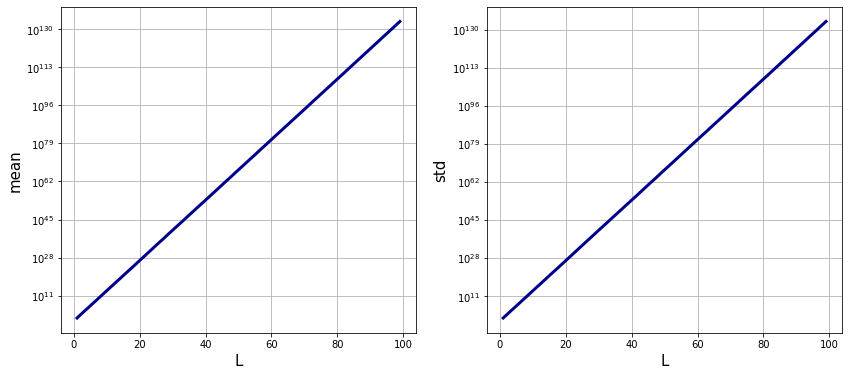

In [10]:
run_test(L=100, activation=relu, init="normal", scale=1, log=True)

#### Uniform distribution

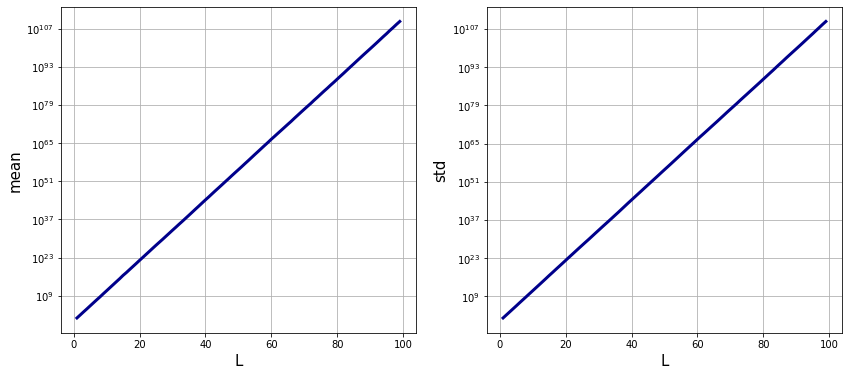

In [11]:
run_test(L=100, activation=relu, init="uniform", bound=1, log=True)

### Vanishing weights/gradients

#### Normal distribution

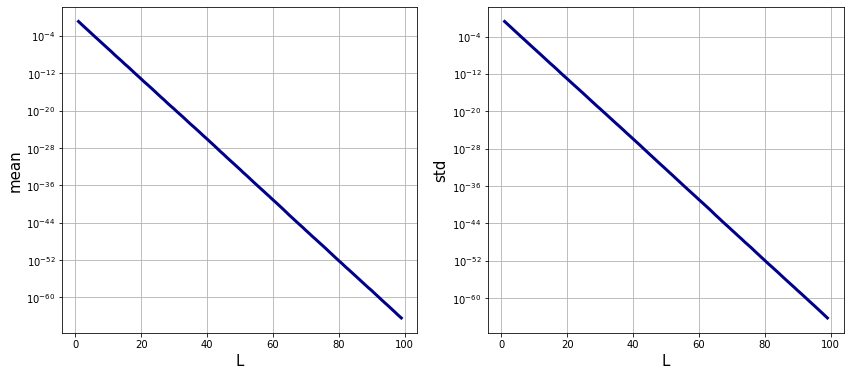

In [12]:
run_test(L=100, activation=relu, init="normal", scale=0.01, log=True)

#### Uniform distribution

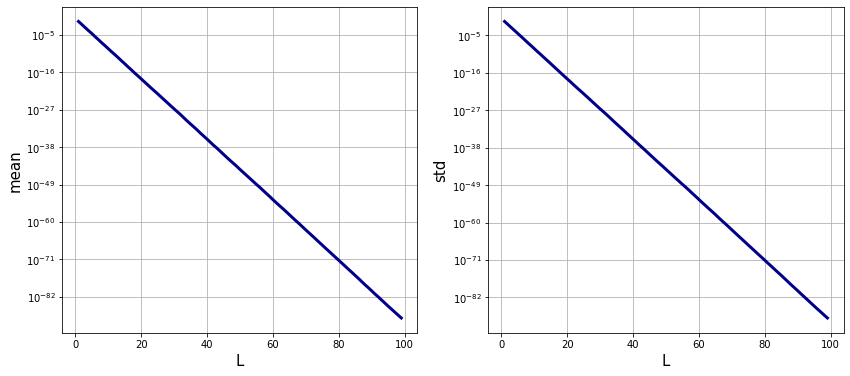

In [13]:
run_test(L=100, activation=relu, init="uniform", bound=0.01, log=True)

### Appropriate Initialization

See https://pytorch.org/docs/stable/nn.init.html

#### Normal distribution

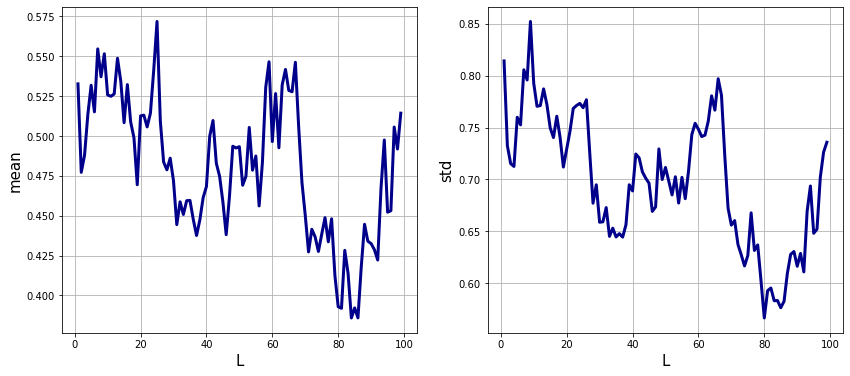

In [14]:
run_test(L=100, activation=relu, init="normal", scale=np.sqrt(2 / D), log=False)

#### Uniform distribution

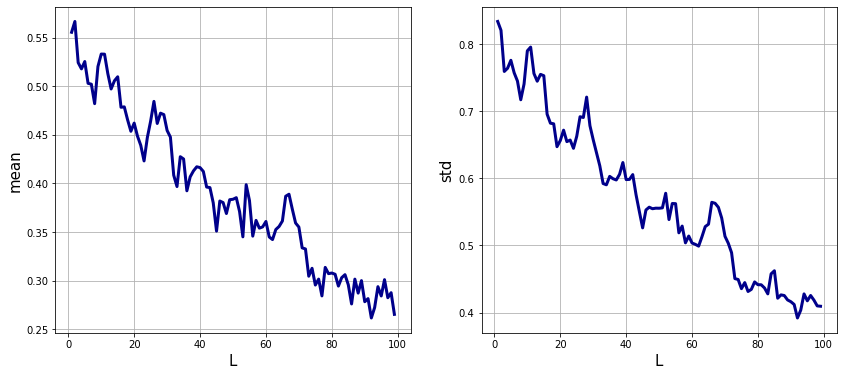

In [15]:
run_test(L=100, activation=relu, init="uniform", bound=np.sqrt(6 / D), log=False)

### LeakyReLU

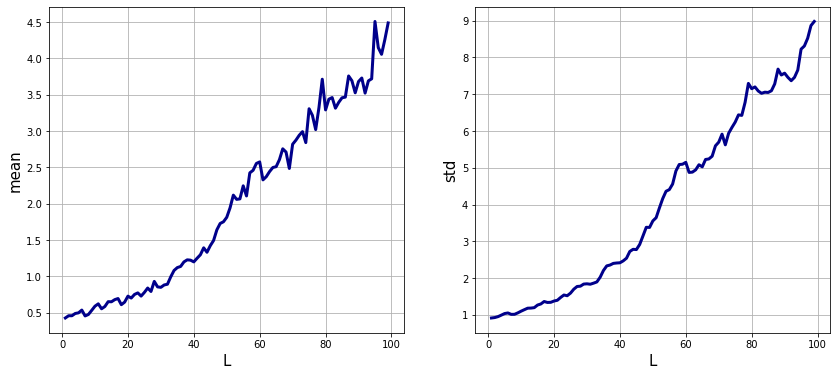

In [16]:
run_test(L=100, activation=leaky_relu, init="normal", scale=np.sqrt(2 / D), log=False)

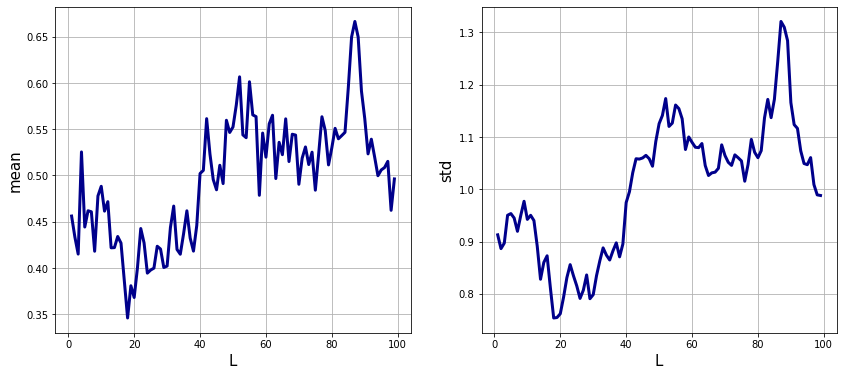

In [17]:
run_test(
    L=100,
    activation=leaky_relu,
    init="normal",
    scale=np.sqrt(2 / (1 + leaky_relu.alpha ** 2) / D),
    log=False,
)

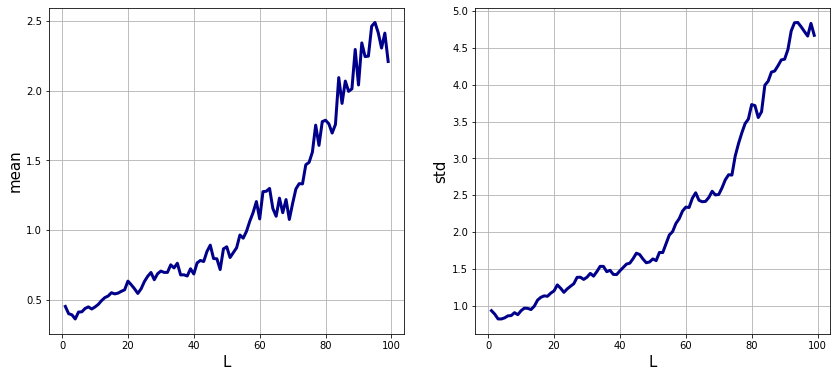

In [18]:
run_test(L=100, activation=leaky_relu, init="uniform", bound=np.sqrt(6 / D), log=False)

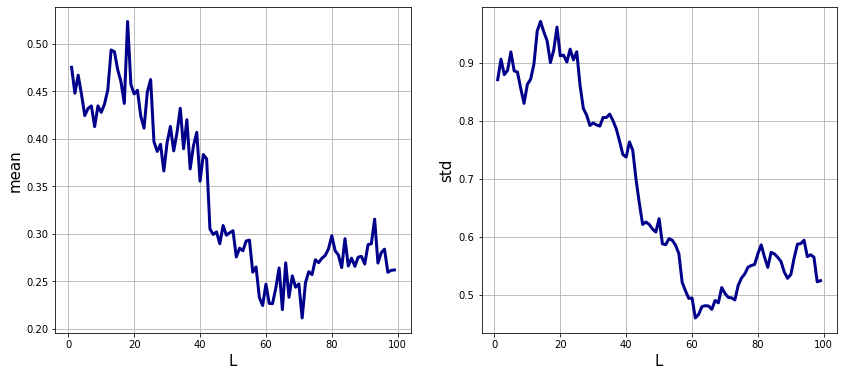

In [19]:
run_test(
    L=100,
    activation=leaky_relu,
    init="uniform",
    bound=np.sqrt(6 / (1 + leaky_relu.alpha ** 2) / D),
    log=False,
)

## Another nice visualization

https://www.deeplearning.ai/ai-notes/initialization/

<br>
&mdash; <br>
Dr. Sebastian Gabel <br>
Machine Learning in Marketing &ndash; Lecture 8 <br>
2021